In [6]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/4_deep_Q-learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train

### Run locally

In [8]:

from rl_introduction.tools import Agent, DeepAgent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train

### Objective
In order to tackle difficult problems (large action-state space and complexity), we will use deep Q learning.

In [9]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.models import Model, load_model
import gym
from time import time,sleep
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
sns.set_style("darkgrid")

In [10]:
# We will experiment our algo with CartPole
env = gym.make('CartPole-v0')

In [11]:
time_steps = 100
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    # env.render()
    sleep(0.04)
# env.close()

# Deep Q-learning

We will parametrize The Q function.
In other words, we are looking for $\theta \in \mathbb{R}^d$ such as 
$\forall s, Q_\theta(s,a) = \mathbb{E}_\pi[G_t | S_t = s, A_t = a]$. We follow the same idea as q-learning:
we learn and update $Q_\theta(S_t,A_t)$ using the target $R_{t+1}+\gamma \max_a Q_\theta(S_{t+1},a)$. A natural loss is the mean square error:

$L(\theta) = \mathbb{E}_{s,a\sim Q} [(y - Q(s,a,\theta))^2]$



$y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$

We have 2 ways to write our function:
1. $Q_\theta : S\times A \rightarrow \mathbb{R}$

in this case greedy policy looks like $\pi(.|s) = \arg\max([Q_\theta(s,a_0), Q_\theta(s,a_1),... Q_\theta(s,a_{dim(A)}]) $

The target is $y = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$


2. $Q_\theta : S \rightarrow \mathbb{R}^{dim(A)}$

in this case greedy policy looks like $\pi(.|s) = \arg\max(Q_\theta(s))$

The target is $y_i = R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)$ for i corresponding to the played action, $Q_\theta(s_t)_i$ otherwise.

In other words, if we played $a$ (second action) in $s$, and we obseved $r$ and $s'$, our target will be (assuming we have 3 actions):

$\begin{aligned}
y_0 =& Q(s,a,\theta)_0\\
y_1 =&R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta)\\
y_2 =&Q(s,a,\theta)_2
\end{aligned}$

And our loss:

$L(\theta) = (R_{t+1} + \gamma \max_a Q(S_{t+1},a,\theta) - Q(s,a,\theta)_1)^2$

In practice implementation 2 is often easier to implement.

In [12]:
# Example of our parametrize Q function (case 2)
def build_model(state_dim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(2, activation='relu')(input_state)
    x = Dense(2, activation='relu')(x)
    x = Dense(action_dim, activation='linear')(x)
    model = Model(inputs=input_state, outputs=x)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

### TODO 1) : write deep Q learning update

In [13]:
#TODO: write deep Q learning update
# Compute the Q target and update the model with keras
class DeepQAgent(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon) 
        self.model = compiled_model
        self.model.summary()
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.env.action_space.n)
        else:
            predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
            return np.argmax(predicted_Qs) 
    
    def train(self, current_state, action, reward, next_state, done):
        pass #complete here

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 2)                 6         
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


2022-03-22 15:56:10.578243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/raphael/rl_introduction/venv/lib/python3.7/site-packages/cv2/../../lib64::/home/raphael/.mujoco/mjpro150/bin
2022-03-22 15:56:10.578272: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 15:56:10.578293: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (raphael-XPS-13-9370): /proc/driver/nvidia/version does not exist
2022-03-22 15:56:10.578865: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with th

episode: 0 - cum reward 9.0
episode: 1 - cum reward 10.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 11.0
episode: 4 - cum reward 11.0
episode: 5 - cum reward 9.0
episode: 6 - cum reward 12.0
episode: 7 - cum reward 10.0
episode: 8 - cum reward 12.0
episode: 9 - cum reward 10.0
episode: 10 - cum reward 9.0
episode: 11 - cum reward 8.0
episode: 12 - cum reward 11.0
episode: 13 - cum reward 11.0
episode: 14 - cum reward 10.0
episode: 15 - cum reward 8.0
episode: 16 - cum reward 8.0
episode: 17 - cum reward 10.0
episode: 18 - cum reward 11.0
episode: 19 - cum reward 9.0
episode: 20 - cum reward 9.0
episode: 21 - cum reward 8.0
episode: 22 - cum reward 9.0
episode: 23 - cum reward 10.0
episode: 24 - cum reward 11.0
episode: 25 - cum reward 8.0
episode: 26 - cum reward 10.0
episode: 27 - cum reward 8.0
episode: 28 - cum reward 10.0
episode: 29 - cum reward 12.0
episode: 30 - cum reward 10.0
episode: 31 - cum reward 11.0
episode: 32 - cum reward 10.0
episode: 33 - cum reward 10.0
epi

episode: 271 - cum reward 32.0
episode: 272 - cum reward 11.0
episode: 273 - cum reward 11.0
episode: 274 - cum reward 12.0
episode: 275 - cum reward 11.0
episode: 276 - cum reward 10.0
episode: 277 - cum reward 11.0
episode: 278 - cum reward 11.0
episode: 279 - cum reward 9.0
episode: 280 - cum reward 10.0
episode: 281 - cum reward 9.0
episode: 282 - cum reward 10.0
episode: 283 - cum reward 9.0
episode: 284 - cum reward 10.0
episode: 285 - cum reward 8.0
episode: 286 - cum reward 13.0
episode: 287 - cum reward 12.0
episode: 288 - cum reward 12.0
episode: 289 - cum reward 12.0
episode: 290 - cum reward 13.0
episode: 291 - cum reward 10.0
episode: 292 - cum reward 18.0
episode: 293 - cum reward 15.0
episode: 294 - cum reward 9.0
episode: 295 - cum reward 20.0
episode: 296 - cum reward 13.0
episode: 297 - cum reward 11.0
episode: 298 - cum reward 11.0
episode: 299 - cum reward 13.0


Text(0.5, 1.0, 'cumulative reward per episode - deep_q_agent')

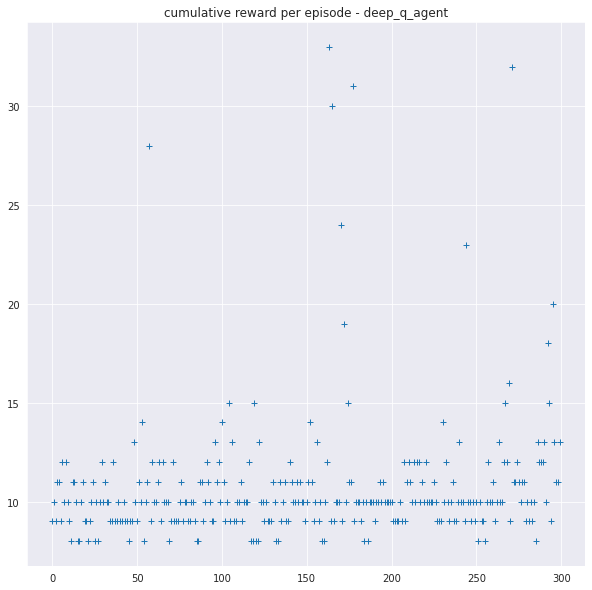

In [15]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)
q_agent = DeepQAgent(env, model)
rewards = run_experiment_episode_train(env, q_agent, 300)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - deep_q_agent')

### TODO 2) : Try different hyerparamters models (number of layers, nodes) and compare learning

In [17]:
### TODO 2) : Try different hyerparamters models (number of layers, nodes, activation) and compare learning
def your_build_model(state_dim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    model = Model(inputs=input_state, outputs=input_state)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

In [18]:
### Done 2) : Try different hyerparamters models (number of layers, nodes) and compare learning
def your_build_model(state_dim, action_dim):
    input_state = Input(name='input_state', shape=(state_dim,), dtype='float32')
    x = Dense(32, activation='relu')(input_state)
    x = Dense(32, activation='relu')(x)
    x = Dense(action_dim, activation='linear')(x)
    model = Model(inputs=input_state, outputs=x)
    model.compile(loss='mse',optimizer=Adam(learning_rate=1e-2))
    return model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 32)                160       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 9.0
episode: 1 - cum reward 9.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 9.0
episode: 4 - cum reward 12.0
episode: 5 - cum reward 9.0
episode: 6 - cum rew

episode: 238 - cum reward 55.0
episode: 239 - cum reward 140.0
episode: 240 - cum reward 47.0
episode: 241 - cum reward 197.0
episode: 242 - cum reward 26.0
episode: 243 - cum reward 190.0
episode: 244 - cum reward 173.0
episode: 245 - cum reward 200.0
episode: 246 - cum reward 178.0
episode: 247 - cum reward 59.0
episode: 248 - cum reward 60.0
episode: 249 - cum reward 78.0
episode: 250 - cum reward 10.0
episode: 251 - cum reward 10.0
episode: 252 - cum reward 10.0
episode: 253 - cum reward 10.0
episode: 254 - cum reward 15.0
episode: 255 - cum reward 16.0
episode: 256 - cum reward 27.0
episode: 257 - cum reward 123.0
episode: 258 - cum reward 57.0
episode: 259 - cum reward 54.0
episode: 260 - cum reward 47.0
episode: 261 - cum reward 61.0
episode: 262 - cum reward 85.0
episode: 263 - cum reward 84.0
episode: 264 - cum reward 30.0
episode: 265 - cum reward 78.0
episode: 266 - cum reward 113.0
episode: 267 - cum reward 122.0
episode: 268 - cum reward 118.0
episode: 269 - cum reward 128

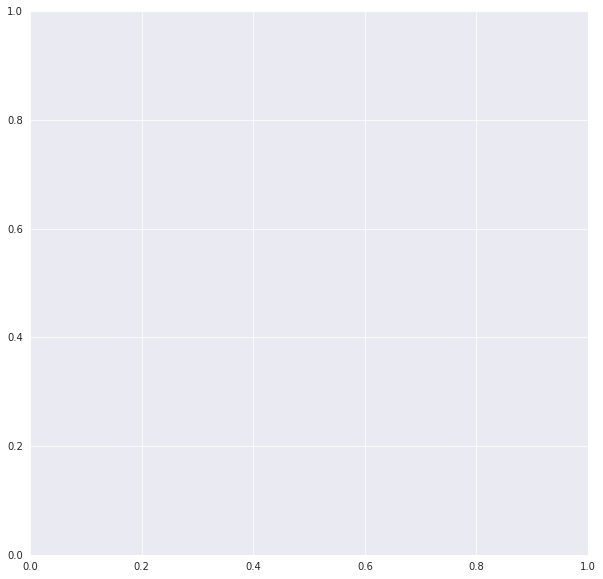

In [19]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
your_model = your_build_model(state_dim, action_dim)
your_q_agent = DeepQAgent(env, your_model)
your_rewards = run_experiment_episode_train(env, your_q_agent, 300)

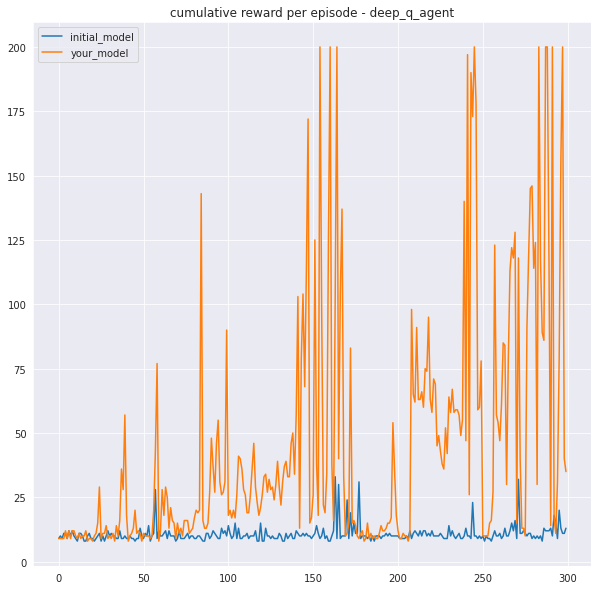

In [22]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,label='initial_model')
ax.plot(your_rewards,label='your_model')
ax.set_title('cumulative reward per episode - deep_q_agent')
ax.legend()

### Experience replay

In order to improve stability, we will keep memory of the previous moves and use it to update our model


$L_i(\theta_i) = \mathbb{E}_{(s, a, r, s') \sim U(D)} \left[ \left(r + \gamma \max_{a'} Q(s', a'; \theta_i^-) - Q(s, a; \theta_i)\right)^2 \right]$

### TODO 3) : Try different hyerparamters models (number of layers, nodes) and compare learning

In [23]:
#TODO: write The function replay that return bacth from memory
# self.memory is a queue of size memory_size
# (x_batch, y_batch)_i is a random (state, target) from the memory
class DeepQAgent_experience_replay(DeepAgent):
    def __init__(self, env, compiled_model, gamma = .99, epsilon = .1, memory_size = 2000, batch_size = 100):
        super().__init__(env, gamma, epsilon)
        
        self.model = compiled_model
        self.model.summary()
        
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        
    def replay(self, batch_size):
        pass #complete here
    
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.env.action_space.n)
            return action
        predicted_Qs = self.model.predict(state.reshape(1, -1))[0]
        action = np.argmax(predicted_Qs) 
        return action
    
    def train(self, current_state, action, reward, next_state, done):
        self.memory.append([current_state, action, reward, next_state, done])
        x_batch, y_batch = self.replay(self.batch_size)
        loss = self.model.train_on_batch(x_batch, y_batch)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_state (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 32)                160       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
episode: 0 - cum reward 9.0
episode: 1 - cum reward 11.0
episode: 2 - cum reward 9.0
episode: 3 - cum reward 9.0
episode: 4 - cum reward 13.0
episode: 5 - cum reward 25.0
episode: 6 - cum r

2022-03-06 13:28:05.705663: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 83 - cum reward 200.0


2022-03-06 13:28:20.880371: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:28:27.674724: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 84 - cum reward 185.0


2022-03-06 13:29:24.301698: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 85 - cum reward 200.0
episode: 86 - cum reward 200.0
episode: 87 - cum reward 200.0
episode: 88 - cum reward 174.0
episode: 89 - cum reward 142.0
episode: 90 - cum reward 200.0
episode: 91 - cum reward 138.0
episode: 92 - cum reward 124.0
episode: 93 - cum reward 169.0
episode: 94 - cum reward 127.0
episode: 95 - cum reward 152.0
episode: 96 - cum reward 57.0
episode: 97 - cum reward 67.0
episode: 98 - cum reward 52.0
episode: 99 - cum reward 40.0
episode: 100 - cum reward 48.0
episode: 101 - cum reward 62.0
episode: 102 - cum reward 53.0
episode: 103 - cum reward 67.0
episode: 104 - cum reward 200.0
episode: 105 - cum reward 200.0
episode: 106 - cum reward 57.0
episode: 107 - cum reward 12.0
episode: 108 - cum reward 10.0
episode: 109 - cum reward 18.0
episode: 110 - cum reward 9.0
episode: 111 - cum reward 73.0
episode: 112 - cum reward 51.0
episode: 113 - cum reward 46.0
episode: 114 - cum reward 171.0
episode: 115 - cum reward 200.0


2022-03-06 13:37:35.689998: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 116 - cum reward 200.0


2022-03-06 13:38:06.429685: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 117 - cum reward 200.0


2022-03-06 13:38:44.453572: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 118 - cum reward 200.0
episode: 119 - cum reward 200.0
episode: 120 - cum reward 200.0
episode: 121 - cum reward 200.0
episode: 122 - cum reward 200.0
episode: 123 - cum reward 200.0
episode: 124 - cum reward 200.0
episode: 125 - cum reward 200.0
episode: 126 - cum reward 200.0
episode: 127 - cum reward 200.0
episode: 128 - cum reward 200.0
episode: 129 - cum reward 200.0
episode: 130 - cum reward 200.0
episode: 131 - cum reward 200.0
episode: 132 - cum reward 200.0
episode: 133 - cum reward 200.0
episode: 134 - cum reward 200.0
episode: 135 - cum reward 200.0
episode: 136 - cum reward 200.0


2022-03-06 13:47:55.265673: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:47:58.862408: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:47:59.285669: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:48:00.253690: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:48:01.989806: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-03-06 13:48:02.417671: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 137 - cum reward 200.0


2022-03-06 13:48:04.829581: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 138 - cum reward 200.0
episode: 139 - cum reward 200.0
episode: 140 - cum reward 200.0
episode: 141 - cum reward 200.0
episode: 142 - cum reward 200.0
episode: 143 - cum reward 118.0
episode: 144 - cum reward 75.0
episode: 145 - cum reward 200.0
episode: 146 - cum reward 200.0
episode: 147 - cum reward 200.0


2022-03-06 13:53:16.630540: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


episode: 148 - cum reward 200.0
episode: 149 - cum reward 200.0
episode: 150 - cum reward 93.0
episode: 151 - cum reward 62.0
episode: 152 - cum reward 86.0
episode: 153 - cum reward 78.0
episode: 154 - cum reward 102.0
episode: 155 - cum reward 200.0
episode: 156 - cum reward 200.0
episode: 157 - cum reward 200.0
episode: 158 - cum reward 200.0
episode: 159 - cum reward 200.0
episode: 160 - cum reward 200.0
episode: 161 - cum reward 200.0
episode: 162 - cum reward 136.0
episode: 163 - cum reward 80.0
episode: 164 - cum reward 25.0
episode: 165 - cum reward 9.0
episode: 166 - cum reward 8.0
episode: 167 - cum reward 46.0
episode: 168 - cum reward 13.0
episode: 169 - cum reward 103.0
episode: 170 - cum reward 59.0
episode: 171 - cum reward 120.0
episode: 172 - cum reward 64.0
episode: 173 - cum reward 200.0
episode: 174 - cum reward 157.0
episode: 175 - cum reward 200.0
episode: 176 - cum reward 117.0
episode: 177 - cum reward 200.0
episode: 178 - cum reward 200.0
episode: 179 - cum rew

Text(0.5, 1.0, 'cumulative reward per episode - memory_deep_q_agent')

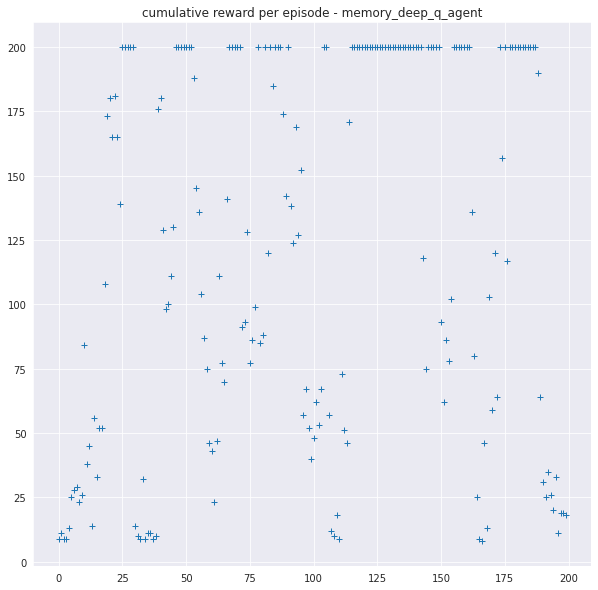

In [13]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = build_model(state_dim, action_dim)

q_agent = DeepQAgent_experience_replay(env, model)
rewards = run_experiment_episode_train(env, q_agent, 200)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - memory_deep_q_agent')

# Other improvments

### epsilon decay
Decay how random you take an action

### clipping reward
$Q(s,a):=Q(s,a)+\alpha(clip(r+\gamma \arg\max(Q(s',a'))-Q(s,a), -1, 1))$

### clipping loss
tf.keras.losses.Huber(delta=1.)

### Double Q learning

DQN: A reinforcement learning algorithm that combines Q-Learning with deep neural networks to let RL work for complex, high-dimensional environments, like video games, or robotics.
Double Q Learning: Corrects the stock DQN algorithm’s tendency to sometimes overestimate the values tied to specific actions.
Prioritized Replay: Extends DQN’s experience replay function by learning to replay memories where the real reward significantly diverges from the expected reward, letting the agent adjust itself in response to developing incorrect assumptions.
Dueling DQN: Splits the neural network into two — one learns to provide an estimate of the value at every timestep, and the other calculates potential advantages of each action, and the two are combined for a single action-advantage Q function.